In [1]:
import numpy as np
import time
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.nn.parameter import Parameter

%matplotlib inline
import pylab as pl

from IPython import display
from copy import deepcopy
from skimage.transform import resize
from PIL import Image

In [2]:
# Set Important Values

data = '/data/dww78/mini_inat_nonproto/'
gpu = 0
torch.cuda.set_device(gpu)
workers = 8
vbity = 20
esize = 4
ngiven = 10
threshold = .15

bsize = 100

In [52]:
# Load Training/Testing Data
threshold = .15
d_train = torch.load(data+'train_boxes.pth')
d_test = torch.load(data+'train_boxes.pth')
d_boxes = torch.load(data+'box_coords.pth')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4905, 0.4961, 0.4330],std=[0.1737, 0.1713, 0.1779])
    ])

def load_transform(path, pathdict, boxdict, transform, size, msize, flipping, masking):
    flip = np.random.choice([True, False])
    with open(path, 'rb') as f:
        p = Image.open(f)
        p = p.convert('RGB')
    w,h = p.size
    p = p.resize((size, size), Image.BILINEAR)
    if flip and flipping:
        p = p.transpose(Image.FLIP_LEFT_RIGHT)
    t = transform(p)
    if masking:
        mask = np.zeros((h,w))
        boxes = pathdict[path]
        for b in boxes:
            box = boxdict[b]
            xmin = box[0]
            xmax = box[2]+xmin
            ymin = box[1]
            ymax = box[3]+ymin
            if not flip or not flipping:
                mask[ymin:ymax, xmin:xmax] = 1
            else:
                mask[ymin:ymax, w-xmax:w-xmin] = 1
        mask = resize(mask, (msize,msize), mode='constant', cval=0, anti_aliasing=False)
        t = [t, (torch.FloatTensor(mask-threshold).sign()/2+.5).unsqueeze(0)]
    return t

class FoldSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, data_source, way):
        iddict = dict()
        for i,(_,cat) in enumerate(data_source.imgs):
            if cat in iddict:
                iddict[cat].append(i)
            else:
                iddict[cat] = [i]
        self.iddict = iddict
        self.way = way
        
    def __iter__(self):
        # Build new dictionary, shuffle entries
        trackdict = deepcopy(self.iddict)
        for key in trackdict:
            np.random.shuffle(trackdict[key])
        # Choose categories, sample, eliminate small categories
        idlist = []
        while len(trackdict.keys()) >= self.way:
            pcount = np.array([len(trackdict[k]) for k in list(trackdict.keys())])
            cats = np.random.choice(list(trackdict.keys()), size=self.way, replace=False, p=pcount/sum(pcount))
            for cat in cats:
                for _ in range(bshot):
                    idlist.append(trackdict[cat].pop())
            for cat in cats:
                for _ in range(foldshot):
                    idlist.append(trackdict[cat].pop())
                if len(trackdict[cat]) < bshot+foldshot:
                    trackdict.pop(cat)
            yield idlist
            idlist = []

class ProtoSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, data_source, way):
        iddict = dict()
        for i,(_,cat) in enumerate(data_source.imgs):
            if cat in iddict:
                iddict[cat].append(i)
            else:
                iddict[cat] = [i]
        self.iddict = iddict
        self.way = way
        
    def __iter__(self):
        # Build new dictionary, shuffle entries
        trackdict = deepcopy(self.iddict)
#         for key in trackdict:
#             np.random.shuffle(trackdict[key])
        # Choose categories, sample, eliminate small categories
        idlist = []
        cats = list(trackdict.keys())[:evalway]
        stopping = False
        while not stopping:
#         while len(trackdict.keys()) >= self.way:
#             pcount = np.array([len(trackdict[k]) for k in list(trackdict.keys())])
                #np.random.choice(list(trackdict.keys()), size=self.way, replace=False, p=pcount/sum(pcount))
            for cat in cats:
                for i in range(bshot):
                    idlist.append(trackdict[cat][i])
            for cat in cats:
                for i in range(trainshot):
                    idlist.append(trackdict[cat][bshot+i])
            for cat in cats:
                for i in range(testshot):
                    idlist.append(trackdict[cat][i])
#                 if len(trackdict[cat]) < bshot+trainshot+testshot:
#                     trackdict.pop(cat)
            yield idlist
            stopping = True
            idlist = []

evalway = 5
bshot = 10
trainshot = 5
testshot = 15
esize = 1
            
test_dataset = datasets.ImageFolder(
    data+'train',
    loader = lambda x: load_transform(x, d_test, d_boxes, transform, 84, 21, False, True))
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_sampler = ProtoSampler(test_dataset, evalway),
    num_workers = workers,
    pin_memory = True)
print('Data loaded!')
print(len(test_dataset.classes))

Data loaded!
227


In [98]:
class Block(nn.Module):
    def __init__(self, insize, outsize):
        super(Block, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(insize, outsize, kernel_size=3, padding=1),
            nn.BatchNorm2d(outsize)
        )
        
    def forward(self, inp):
        return self.layers(inp)

# New model (with 4th channel)
class PROTO(nn.Module):
    def __init__(self, inC):
        super(PROTO, self).__init__()
        self.process = nn.Sequential(
            Block(inC,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.AvgPool2d(10)
        )
        
    def forward(self, inp):
        return self.process(inp).view(inp.size(0),-1)
    
class bPROTO(nn.Module):
    def __init__(self):
        super(bPROTO, self).__init__()
        self.process = nn.Sequential(
            Block(3,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.ReLU(inplace=True),
            Block(64,64)
        )
        
    def forward(self, inp):
        return self.process(inp)
    
class cPredictor(nn.Module):
    def __init__(self):
        super(cPredictor, self).__init__()
        
    def forward(self, inp, masks, way, shot):
        support = inp.unsqueeze(-1) # B 64 21 21 1
        m = masks.unsqueeze(1) # B 1 1 21 21
        c = torch.stack([1-m, m], dim=-1) # B 1 1 21 21 2     (Positive class corresponds to index/label 1)
        c = (c*support).contiguous() # B B 64 21 21 2
        for i in range(way):
            print(c.size(), c[i].mean())
        c = c.view(way,shot,inp.size(1),-1,2).mean(3).mean(1) # W 64 2
        return c
        
class bPredictor(nn.Module):
    def __init__(self):
        super(bPredictor, self).__init__()
        self.sm = nn.Softmax(dim=-1)
        self.upper = nn.Upsample(size=(84,84), mode='bilinear')
        
    def forward(self, inp, c):
        c = c.unsqueeze(2).unsqueeze(2).unsqueeze(1) # W 1 64 1 1 2
        query = inp.view(c.size(0), -1, inp.size(1), inp.size(2), inp.size(3), 1) # W S 64 21 21 1
        distmat = ((c-query)**2).sum(2).neg().view(-1, inp.size(2), inp.size(3), 2) # B 21 21 2
        probs = self.sm(distmat)[:,:,:,1]
        return self.upper(probs.unsqueeze(1))
    
class Predictor(nn.Module):
    def __init__(self):
        super(Predictor, self).__init__()
        self.sm = nn.LogSoftmax(dim=-1)
        
    def forward(self, support, query, way):
        assert support.size(0)%way == 0,"Error: classes are not the same size!"
        shot = support.size(0)//way
        support = support.view(way,shot,-1)
        centroids = torch.mean(support, 1).view(support.size(0),-1)
#         pl.imshow(centroids.data.cpu().numpy())
        if self.training:
            centroids = centroids.unsqueeze(0).unsqueeze(0) # w 1 1 d
            support = support.unsqueeze(2) # w s 1 d
            eye = torch.eye(way).unsqueeze(1).unsqueeze(-1).cuda()/shot # w 1 w 1
            rescaler = (torch.eye(way)/(shot-1) + torch.ones(way,way)).unsqueeze(1).unsqueeze(-1).cuda()
            realc = (centroids - support*eye)*rescaler # w s w d
            distmat = torch.sum((realc-support)**2, -1).squeeze().view(-1,way).neg() # ws w
        else:
            distmat = torch.sum((centroids.unsqueeze(0)-query.unsqueeze(1))**2,2).squeeze().neg()
        probs = self.sm(distmat)
        return probs
    
predictor = Predictor().cuda()
cpredictor = cPredictor().cuda()
bpredictor = bPredictor().cuda()
criterion = nn.NLLLoss().cuda()

m = 0
smodel = PROTO(4).cuda()
bmodel = bPROTO().cuda()
b = torch.load('detectors/saved_models/box_predictors.pth')
s = torch.load('saved_models/bpred_retrained.torch')
smodel.load_state_dict(s[m])
bmodel.load_state_dict(b[0])
smodel = smodel.eval()
bmodel = bmodel.eval()
smodel = [smodel,]

print("Models built!")

Models built!


In [77]:
def validate(val_loader, gpu, vbity, reps, verbose):
    for model in smodel:
        model.eval()
    bmodel.eval()
    predictor.eval()
    targ = Variable(torch.LongTensor([i//testshot for i in range(testshot*evalway)])).cuda(
        device = gpu, async=True)
    allloss = [0]*esize
    acctracker = [[] for _ in range(esize)]
    for r in range(reps):
        for i, ((inp, m), _) in enumerate(val_loader):
            inp = Variable(inp).cuda(device = gpu, async=True)
            m = Variable(m).cuda(device = gpu, async=True)
            with torch.no_grad():
                c = cpredictor(bmodel(inp[:evalway*bshot]), m[:evalway*bshot], evalway, bshot).detach()
                smasks = bpredictor(bmodel(inp[evalway*bshot:evalway*(bshot+trainshot)]), c).detach()
                qmasks = bpredictor(bmodel(inp[evalway*(bshot+trainshot):]), c).detach()
                pl.figure(figsize=(20,10))
                for i in range(evalway):
                    pl.subplot(1,evalway,i+1)
                    pl.imshow(qmasks[i*testshot].squeeze().data.cpu().numpy(), vmin=0, vmax=1)
                pl.show()
                masks = torch.cat([smasks,qmasks], dim=0)
                inp = torch.cat([inp[evalway*bshot:], masks], dim=1)

                for j in range(esize):
                    centroids = smodel[j](inp[:evalway*trainshot])
                    out = predictor(centroids, smodel[j](inp[evalway*trainshot:]), evalway)
                    loss = criterion(out, targ)
                    allloss[j] += loss.item()
                    _,bins = torch.max(out,1)
                    acc = torch.sum(torch.eq(bins,targ)).item()/testshot/evalway
                    acctracker[j].append(acc)
            if i%vbity == 0 and verbose:
                print('Round %d of %d, %d of approx. 51716'%(r+1, reps, i*evalway*(bshot+trainshot+testshot)))
    return [L/(i+1) for L in allloss], [np.mean(a) for a in acctracker], [1.96*np.sqrt(np.var(a)/len(a)) for a in acctracker]

torch.Size([50, 50, 64, 21, 21, 2]) tensor(0.1000, device='cuda:0')
torch.Size([50, 50, 64, 21, 21, 2]) tensor(0.1000, device='cuda:0')
torch.Size([50, 50, 64, 21, 21, 2]) tensor(0.1000, device='cuda:0')
torch.Size([50, 50, 64, 21, 21, 2]) tensor(0.1000, device='cuda:0')
torch.Size([50, 50, 64, 21, 21, 2]) tensor(0.1000, device='cuda:0')


/home/dww78/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/dww78/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


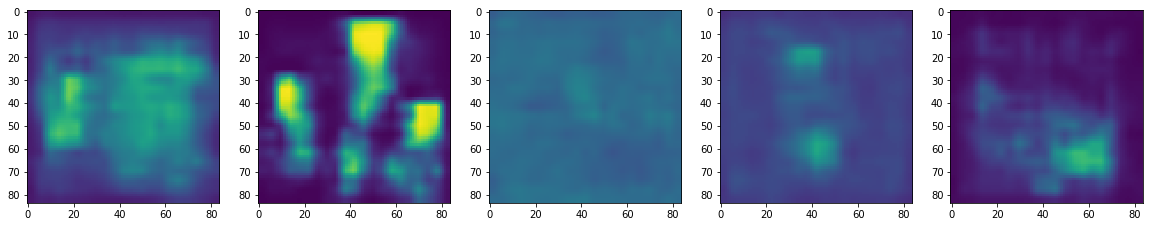

Model 0 final score: 97.33 +- 0.00


In [99]:
_, score, conf = validate(test_loader, gpu, vbity, 1, True)
for i in range(esize):
    print('Model %d final score: %.2f +- %.2f'%(i, score[i]*100, conf[i]*100))

tensor(1.) tensor(0.)


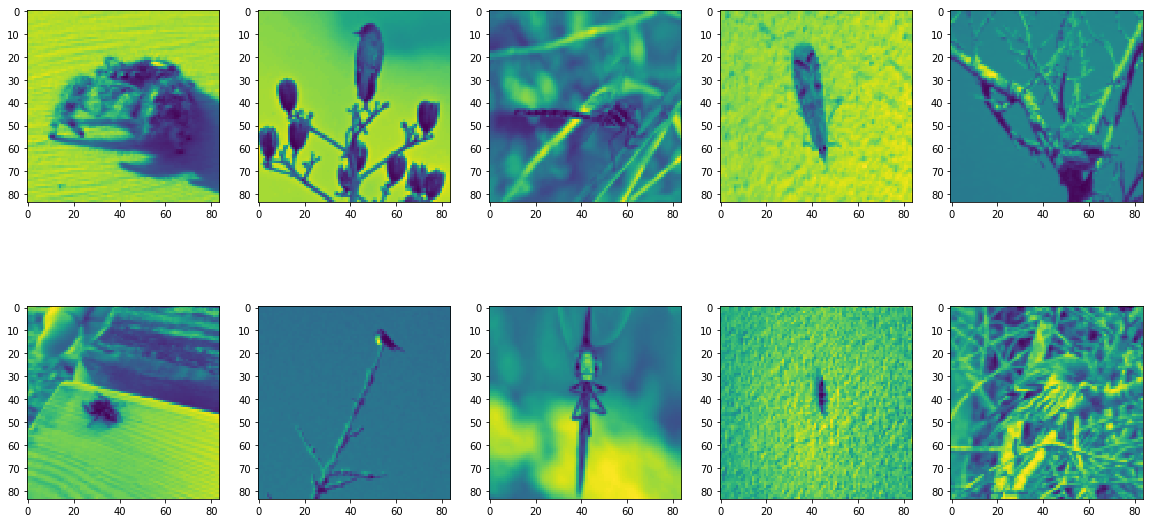

In [79]:
for i, ((inp, m), _) in enumerate(test_loader):
    pl.figure(figsize=(20,10))
    for j in range(evalway):
        pl.subplot(2,evalway,j+1)
        pl.imshow(inp[j*bshot,0].data.cpu().numpy())
        pl.subplot(2,evalway,evalway+j+1)
        pl.imshow(inp[evalway*bshot + j*trainshot,0].data.cpu().numpy())